Importing Needed Libraries

In [8]:
#Step 1: Import Libraries
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Loading and Preprocessing Dataset

In [9]:
# Step 2: Load and Prepare Dataset
df = pd.read_csv("Recipe Reviews and User Feedback Dataset.csv")
df = df.dropna(subset=["text"])  # Drop missing text
df = df[df["stars"].isin([0, 1, 2, 4, 5])]  # Remove neutral (3-star) reviews
df["label"] = df["stars"].apply(lambda x: 1 if x >= 4 else 0)  # Binary mapping

texts = df["text"].values
labels = df["label"].values


TF-IDF Vectorization

In [10]:
#Step 3: TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X = vectorizer.fit_transform(texts)

Defining Support Vector Machine(SVM) Evalution Function

In [11]:

#Step 4: Define SVM Evaluation Function
def evaluate_svm(X, y, C_values, sample_ratios):
    results = []

    for sample_ratio in sample_ratios:
        if sample_ratio < 1.0:
            X_part, _, y_part, _ = train_test_split(X, y, train_size=sample_ratio, stratify=y, random_state=42)
        else:
            X_part, y_part = X, y

        X_train, X_test, y_train, y_test = train_test_split(X_part, y_part, test_size=0.2, stratify=y_part, random_state=42)

        for C in C_values:
            model = LinearSVC(C=C, max_iter=50000)
            start_time = time.time()
            model.fit(X_train, y_train)
            training_time = time.time() - start_time

            y_pred = model.predict(X_test)
            acc_holdout = accuracy_score(y_test, y_pred)
            f1_holdout = cross_val_score(model, X_train, y_train, cv=5, scoring="f1_weighted").mean()
            f1_cv_full = cross_val_score(model, X_part, y_part, cv=5, scoring="f1_weighted").mean()

            results.append({
                "Sample Ratio": sample_ratio,
                "C": C,
                "Accuracy (Holdout)": acc_holdout,
                "F1 (Holdout CV)": f1_holdout,
                "F1 (Full CV)": f1_cv_full,
                "Training Time (s)": training_time
            })

    return pd.DataFrame(results)


Runing Evaluation

In [12]:
#Step 5: Run Evaluation
C_values = [0.1, 1.0, 10.0]
sample_ratios = [1.0, 0.5, 0.25]
results_df = evaluate_svm(X, labels, C_values, sample_ratios)

print("Evaluation Complete")
print(results_df)

Evaluation Complete
   Sample Ratio     C  Accuracy (Holdout)  F1 (Holdout CV)  F1 (Full CV)  \
0          1.00   0.1            0.880441         0.830432      0.833034   
1          1.00   1.0            0.885246         0.854693      0.851531   
2          1.00  10.0            0.856133         0.839572      0.831461   
3          0.50   0.1            0.876767         0.821906      0.823540   
4          0.50   1.0            0.880158         0.853067      0.855105   
5          0.50  10.0            0.847937         0.829110      0.831884   
6          0.25   0.1            0.876836         0.816577      0.817996   
7          0.25   1.0            0.874576         0.847338      0.842192   
8          0.25  10.0            0.838418         0.831818      0.826968   

   Training Time (s)  
0           0.064493  
1           0.057603  
2           0.124705  
3           0.013831  
4           0.025790  
5           0.046525  
6           0.003939  
7           0.011562  
8           

Plotting Results

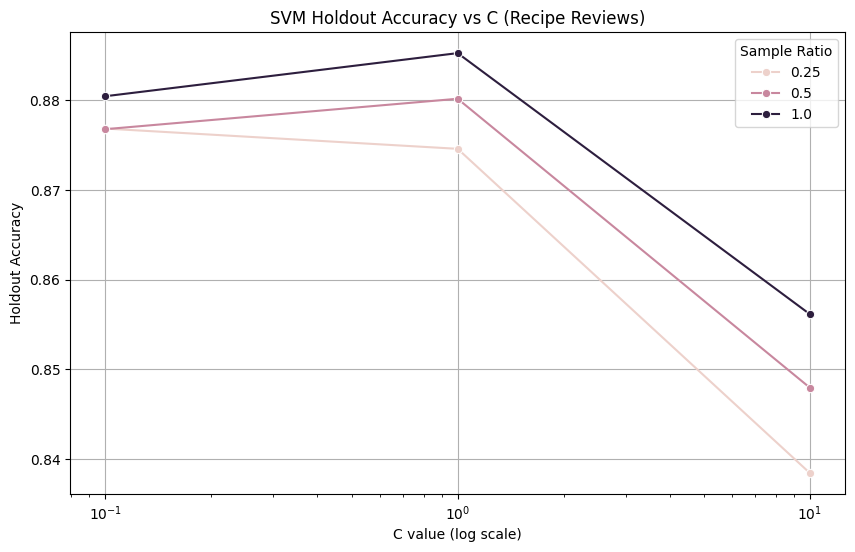

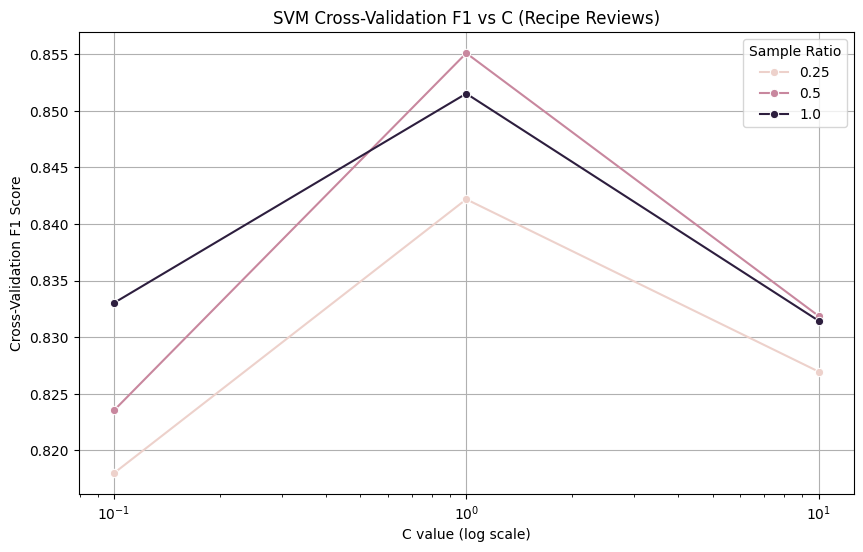

In [13]:






#Step 6: Plot Results
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x="C", y="Accuracy (Holdout)", hue="Sample Ratio", marker="o")
plt.xscale('log')
plt.title("SVM Holdout Accuracy vs C (Recipe Reviews)")
plt.xlabel("C value (log scale)")
plt.ylabel("Holdout Accuracy")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x="C", y="F1 (Full CV)", hue="Sample Ratio", marker="o")
plt.xscale('log')
plt.title("SVM Cross-Validation F1 vs C (Recipe Reviews)")
plt.xlabel("C value (log scale)")
plt.ylabel("Cross-Validation F1 Score")
plt.grid(True)
plt.show()
